## V.1 Exploring the green reds
### a) Write a function that will plot a scatterplot matrix of your red wine data.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd

# white_df = pd.read_csv("resources/winequality-white.csv", sep=";")
red_df = pd.read_csv("resources/winequality-red.csv", sep=";") 

def plot_scatter_matrix(wine_data: pd.DataFrame, good_threshold: int, bad_threshold: int, save_plot=False):
    """
    Plot the performance of our perceptron or adaline.
    this function will produce graphs which shows dependence between
    every two factors.
    """
    assert good_threshold > bad_threshold, "Please, enter good_treshold sctrictly > than bad_treshold"
    q = wine_data['quality']    

    labels = wine_data.columns[:-1]
    assert len(labels) >=2, "there have to be at least 2 labels ti build dependence"
    f, axarr = plt.subplots(len(labels), len(labels), figsize=(20, 20))
    f.suptitle('Dependence between acidity and quality')
    f.subplots_adjust(wspace=0, hspace=0)

    k = 0
    for x in [wine_data[label] for label in labels]:
        j = 0
        for y in [wine_data[label] for label in labels]:
            axarr[k][j].set_xticks([])
            axarr[k][j].set_yticks([])
            if k == j:
                axarr[k][j].text(0.1, 0.5, labels[k], fontsize=11)
            else:
                colors = [('orchid' if q[i]<= bad_threshold else ('green' if q[i]>=good_threshold else 'None'))\
                          for i in range(wine_data.shape[0])]
                axarr[k][j].scatter(x, y, marker='.', c=colors)
            j+=1
        k+=1
    plt.savefig('fig.png') if save_plot else 0
    return 

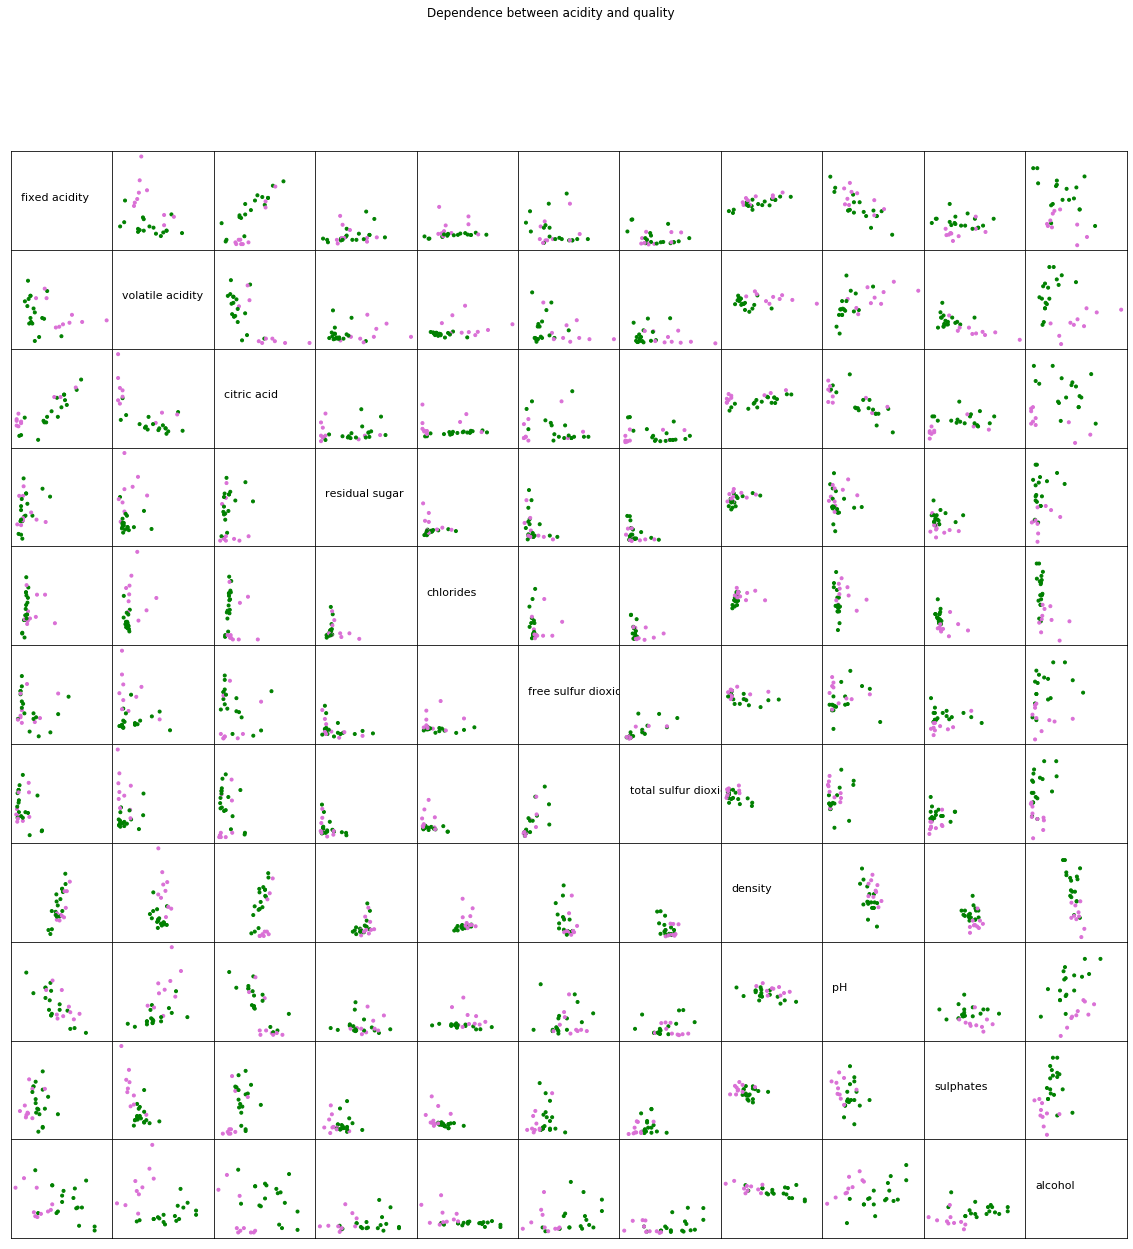

In [2]:
plot_scatter_matrix(red_df, 8, 3, False)

b) Now that you’ve had a chance to analyze different chemical factors in red wines and
their relationship with high scores (8 or higher) and low scores (3 or lower), which
factors do you think will be most useful to your perceptron for distinguishing high
quality vs. low quality wines? Why?

Alcohol: because the higher alcohol factor the higher quality.
Sulphates, Chlorides, Volatile Acidity though not in such degree.

## V.2 Learning to perceptron
### a), b) & c)

In [3]:
from math import exp
import random
random.seed(1777)

def inf():
    i = 0
    while True:
        yield i
        i += 1

def dot(a: list, b: list) -> float:
    """
    Scalar product of 2 vectors a and b
    """
    assert len(a) == len(b), "Vectors must be equal length!"
    return sum([a[i] * b[i] for i in range(len(a))])

class Perceptron(object):

    def __init__(self, threshold, learning_rate =0.4, epochs=0):
        self.learning_rate = learning_rate
        self.epochs = epochs 
        self.res = []
        self.threshold = threshold
        return
    
    def error(self, y: list, d: list) -> int:
        return sum(abs(d-y))

    def train(self, x: list, d: list): 
        """
        train perceptron on received data
        x - received data (matrix, row - one specific wine)
        d - desired output (good(1) or bad(0) wines good=(quality>threshold))
        """
        assert (len(x) == len(d)), "x should have the same amount of rows as d"
        self.w = [random.random() for i in range(len(x[0]))]
        self.bias = random.random()
        y = [int(random.random() > 0.5) for _ in range(len(x))]
        self.res.append([0, self.error(y, d), self.w, self.bias])
        for i in inf() if self.epochs == 0 else range(self.epochs):
            for row in range(len(x)):
                y[row] = int(dot(x[row], self.w) + self.bias >= self.threshold)
                error = d[row] - y[row]
                for col in range(len(x[row])):
                    self.w[col] += self.learning_rate * error * x[row][col]
                self.bias += self.learning_rate * error
            self.res.append([i, self.error(y, d), self.w, self.bias])
            if self.epochs == 0 and self.res[-1][1] == 0:
                break
        return
    
    def predict(self, x):
        return int(dot(self.w, x) + self.bias >= self.threshold)

    
def plot_cost(performance, epoch, ax):
    if epoch < 0 or epoch > performance[-1][0]:
        print(f'epoch was : {epoch}')
        epoch = performance[-1][0]
    errors = [performance[i][1]  for i in range(len(performance))]
    epochs = [performance[i][0]  for i in range(len(performance))]
    ax.plot(epochs, errors, c='b')
    ax.set_xlabel('iterations')
    ax.set_ylabel('cost')
    ax.set_title('Errors as a function of epochs')
    return
    
pink, green = (0.976, 0.854, 0.992), (0.866, 0.921, 0.854)
def plot_performance(performance, wine_data, good_thresh, bad_thresh, factors: list, epoch=-1, save_plot=False):
    """
    Plot the performance of our perceptron or adaline.
    this function will produce a two plot figure:
    1) Classification Errors vs. Epochs
    2) Decision boundary for two factors
    """
    f, ax = plt.subplots(1, 2, figsize=(20, 8))
    plot_cost(performance, epoch, ax[0])
    
    b = performance[epoch][3]
    w1 = performance[epoch][2][0]
    w2 = performance[epoch][2][1]
    assert w2 != 0, "w2 = 0"
    f1 = [i for i in range(-50, 50)]
    f2 = [ (good_thresh - b - w1 * f1[j]) / w2 for j in range(len(f1))]

    ax[1].set_xlim(min(wine_data[factors[0]].values)-0.1, max(wine_data[factors[0]].values)+0.1)
    ax[1].set_ylim(min(wine_data[factors[1]].values)-0.1, max(wine_data[factors[1]].values)+0.1)
    ax[1].plot(f1, f2, linestyle='--', color='b', label='Decision Boundary')
   
    goods = wine_data[wine_data.quality >= good_thresh]
    bads = wine_data[wine_data.quality <= bad_thresh]
    xg, yg = goods[factors[0]].values, goods[factors[1]].values
    xb, yb = bads[factors[0]].values, bads[factors[1]].values

    # count good dots and define how to fill the field
    right_color, left_color = green, pink
    upper_dots = 0
    for xi, yi in zip(xb, yb):
        if (good_thresh - b - w1 * xi) / w2 < yi:
            upper_dots += 1
    if upper_dots > len(xb) / 2:
        right_color, left_color = pink, green
    
    ax[1].fill_between(f1, f2, max(f1)+5, facecolor=right_color)
    ax[1].fill_between(f1, f2, min(f1)-5, facecolor=left_color)
    ax[1].scatter(xg, yg, marker='.', c='green', label=f'good wines(>{good_thresh-1} score)')
    ax[1].scatter(xb, yb, marker='.', c='orchid', label=f'bad wines(<{bad_thresh+1} score)')
    ax[1].set_title(f'Decision boundary on epoch {epoch}')
    ax[1].set_xlabel(factors[0]) 
    ax[1].set_ylabel(factors[1])
    plt.legend(loc='upper left', bbox_to_anchor=(1, 0.5))
    print(f'b = {round(b,1)}, w1 = {round(w1, 1)}, w2 = {round(w2, 1)},\
    x2 = {round((good_thresh - b)/w2,2)}-x1*{round(w1/w2,2)}')
    plt.show()
    return
# V.2.end

### d) Feature scaling

In [4]:
def feature_scaling(x: pd.DataFrame):
    print('Feature scaling is on.')
    means, maxs, mins = {}, {}, {}
    for feature in x.columns[:-1]:
        means[feature] = sum(x[feature]) / len(x[feature])
        maxs[feature] = max(x[feature])
        mins[feature] = min(x[feature])
    
    scaled_x = x.copy(deep=True)
    for feature in scaled_x.columns[:-1]:
        for j in range(len(scaled_x[feature])):
            scaled_x.loc[j, feature] = (x[feature][j] - means[feature]) / (maxs[feature] - mins[feature])
    print('Data scaled.')
    return scaled_x

Feature scaling is on.
Data scaled.
b = 8.1, w1 = 1.3, w2 = -1.4,    x2 = 0.04-x1*-0.99


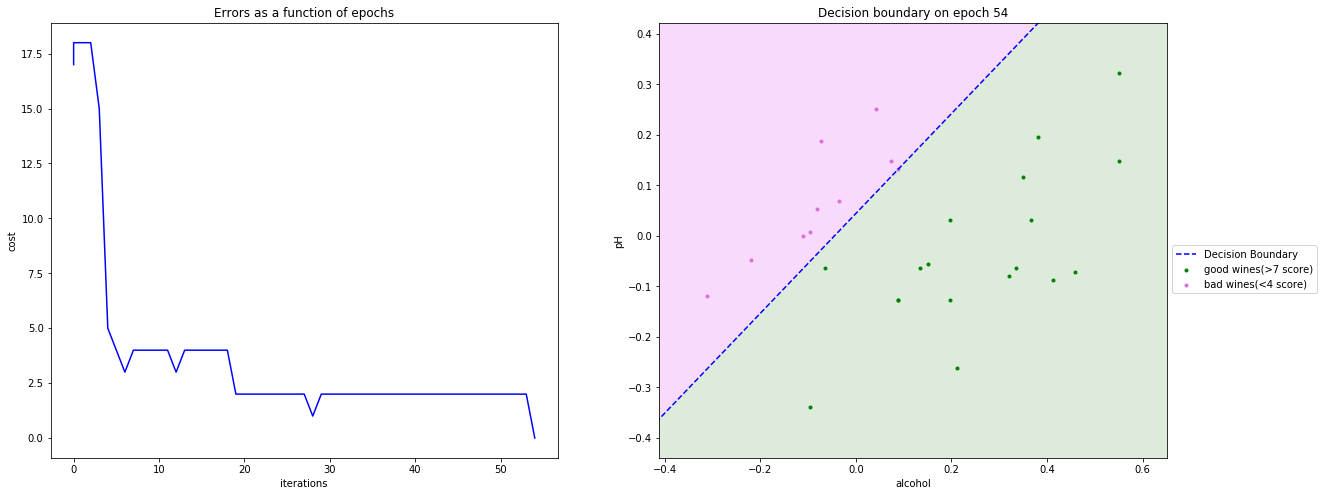

In [5]:
def prepare_data_and_train(wine_data: pd.DataFrame, learning_rate, \
                           factors: list, wines_threshs: list, epochs: int):
    perceptron = Perceptron(wines_threshs[1], learning_rate, epochs)
    part = wine_data[(wine_data.quality <= wines_threshs[0]) | (wine_data.quality >= wines_threshs[1])]
    part.index = range(len(part))
    x = part[factors].values
    d = (part['quality'] >= wines_threshs[1]).astype(int)
    perceptron.train(x, d)
    plot_performance(perceptron.res, part, wines_threshs[1], wines_threshs[0], factors, perceptron.res[-1][0])
    return


red_df = pd.read_csv("resources/winequality-red.csv", sep=";") 
# prepare_data_and_train(red_df, 0.1, ['alcohol', 'pH'], [3, 8], 0)

# feature scaling
red_df = feature_scaling(red_df)
prepare_data_and_train(red_df, 0.1, ['alcohol', 'pH'], [3, 8], 0)

# prepare_data_and_train(red_df, 0.1, ['chlorides', 'sulphates'], [3, 8], 10000)
# prepare_data_and_train(red_df, 0.1, ['volatile acidity', 'alcohol'], [3, 8], 10000)
# prepare_data_and_train(red_df, 0.01, ['density', 'volatile acidity'], [3, 8], 10000)
# prepare_data_and_train(red_df, 0.1, ['density', 'volatile acidity'], [3, 8], 10000)

## V.3 My fair ADALINE
### a) Torturing perceptron

b = 7.1, w1 = 0.4, w2 = -0.3,    x2 = 0.27-x1*-1.16


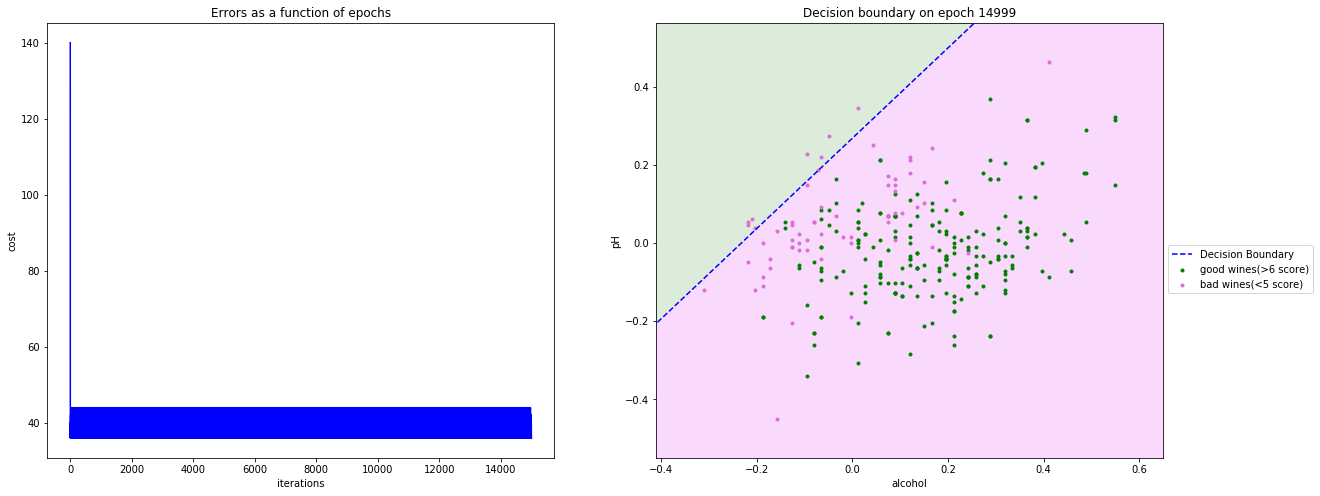

In [6]:
prepare_data_and_train(red_df, 0.1, ['alcohol', 'pH'], [4, 7], 15000)

## V.3 My fair ADALINE :  
### b), c) & d)

In [7]:
class Adaline(object):

    def __init__(self, threshold, learning_rate=0.01, epochs=0):
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.res = []
        self.current_epoch = 0
        self.threshold = threshold
        self.w = []
        return
 
    def error(self, y: list, d: list) -> float:
        r = 0
        for i in range(len(d)):
            r += (d[i] - y[i]) * (d[i] - y[i])
        r = r / 2
        return r

    def do_step_batch(self, x, y, d):
        """
        update weights for each row once (batch)
        """
        for row in range(len(x)):
            updates = [0 for i in range(len(x[0]))]
            bias_update = 0
            y[row] = dot(x[row], self.w) + self.bias
            error = d[row] - y[row]
            for col in range(len(x[row])):
                updates[col] += self.learning_rate * error * x[row][col]
            bias_update += self.learning_rate * error
        self.bias += bias_update
        for col in range(len(x[row])):
            self.w[col] += updates[col]
        self.current_epoch +=1
        self.res.append([self.current_epoch, self.error(y, d), self.w, self.bias])
        return
    
    def do_step_online(self, x, y, d):
        """
        update weights for each row once (batch)
        """        
        for row in range(len(x)):
            y[row] = dot(x[row], self.w) + self.bias
            error = d[row] - y[row]
            for col in range(len(x[row])):
                self.w[col] += self.learning_rate * error * x[row][col]
            self.bias += self.learning_rate * error
        self.current_epoch +=1
        self.res.append([self.current_epoch, self.error(y, d), self.w, self.bias])
        return
          
    def train(self, x: list, d: list, online=True, reinitialize_weights=True):
        """
        train adaline on received data
        x - received data (matrix, row - one specific wine)
        d - desired output
        """
        assert (len(x) == len(d)), "x should have the same amount of rows as d"
        if len(self.w) != len(x[0]) or reinitialize_weights:
            self.w = [random.random() for i in range(len(x[0]))]
            self.bias = random.random()
        y = [random.random() * 10 for _ in range(len(x))]
        self.res.append([self.current_epoch, self.error(y, d), self.w, self.bias])
        step = self.do_step_online if online else self.do_step_batch
        for i in inf() if self.epochs == 0 else range(self.epochs):
            step(x, y, d)
            if self.epochs == 0 and i > 2 and abs(self.res[-2][1]) < abs(self.res[-1][1]):
                break
        print(f'Learning rate: {self.learning_rate}, cost/rows: {self.res[-1][1] / len(x)}')
        return
    
    def predict(self, x):
        return dot(self.w, x) + self.bias
# V.3 _end_  

Learning rate: 0.001, cost/rows: 0.5898158218974177
b = 5.8, w1 = 4.7, w2 = -4.0,    x2 = -0.31-x1*-1.18


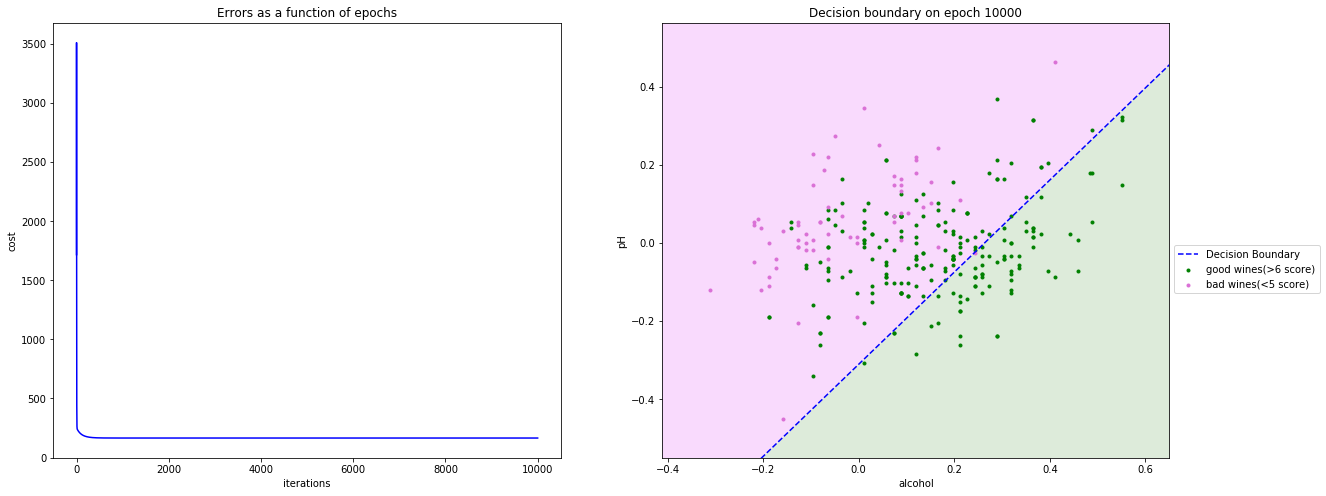

In [8]:
def prepare_data_and_train_ada(wine_data: pd.DataFrame, learning_rate, \
                               factors: list, wines_threshs: list, epochs: int, online=True):
    ada = Adaline(wines_threshs[1], learning_rate, epochs)
    part = wine_data[(wine_data.quality >= wines_threshs[1]) | (wine_data.quality <= wines_threshs[0])]
    part.index = range(len(part))
    x = part[factors].values
    d = part['quality']
    ada.train(x, d, online)
    plot_performance(ada.res, part, wines_threshs[1], wines_threshs[0], factors, ada.current_epoch)
    return

learning_rate, online = 0.01, True

# showtime
# prepare_data_and_train_ada(red_df, 0.1, ['alcohol', 'pH'], [3, 8], 4)
# prepare_data_and_train_ada(red_df, 0.001, ['alcohol', 'pH'], [3, 8], 4)
# prepare_data_and_train_ada(red_df, 0.0001, ['alcohol', 'pH'], [3, 8], 4)

# prepare_data_and_train_ada(red_df, 0.01, ['alcohol', 'pH'], [4, 7], 10000, online)
prepare_data_and_train_ada(red_df, 0.001, ['alcohol', 'pH'], [4, 7], 10000, online)
# prepare_data_and_train_ada(red_df, 0.0001, ['alcohol', 'pH'], [4, 7], 10000, online)
# prepare_data_and_train_ada(red_df, 0.001, ['alcohol', 'pH'], [4, 7], 10000, False)

# V.4 Advanced wine sampling and resampling 
### a) holdout  & b) k-fold cross-validation

Learning rate: 0.01, cost/rows: 0.6550071712707395
b = 5.8, w1 = -3.8, w2 = 4.3,    x2 = 0.28-x1*-0.88


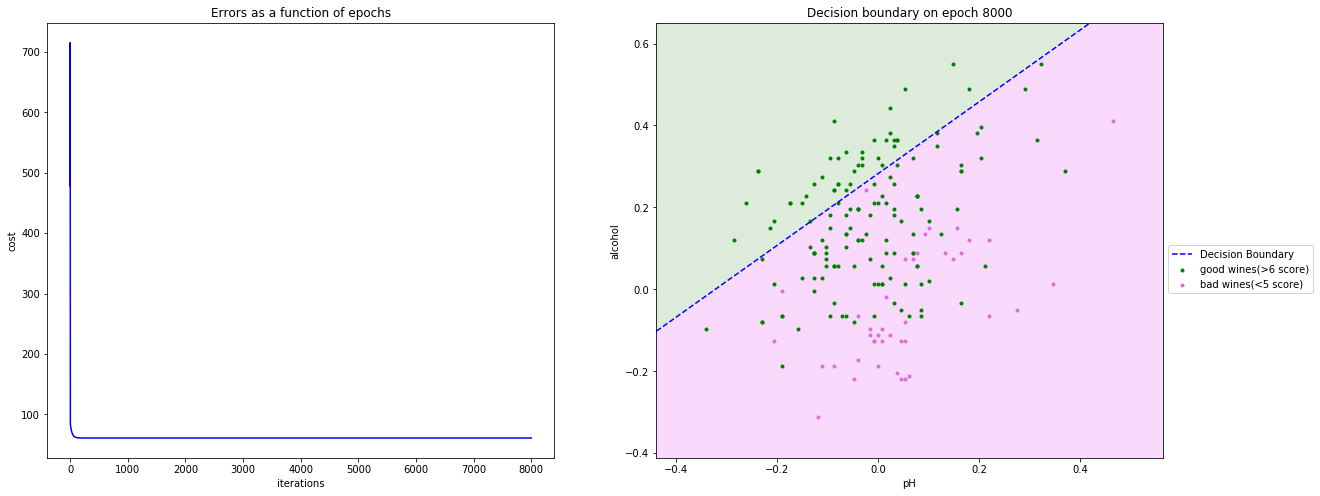

learning rate: 0.01, cost = 60.91566692817877
Learning rate: 0.001, cost/rows: 0.5852206941129148
b = 5.8, w1 = -3.7, w2 = 4.9,    x2 = 0.24-x1*-0.77


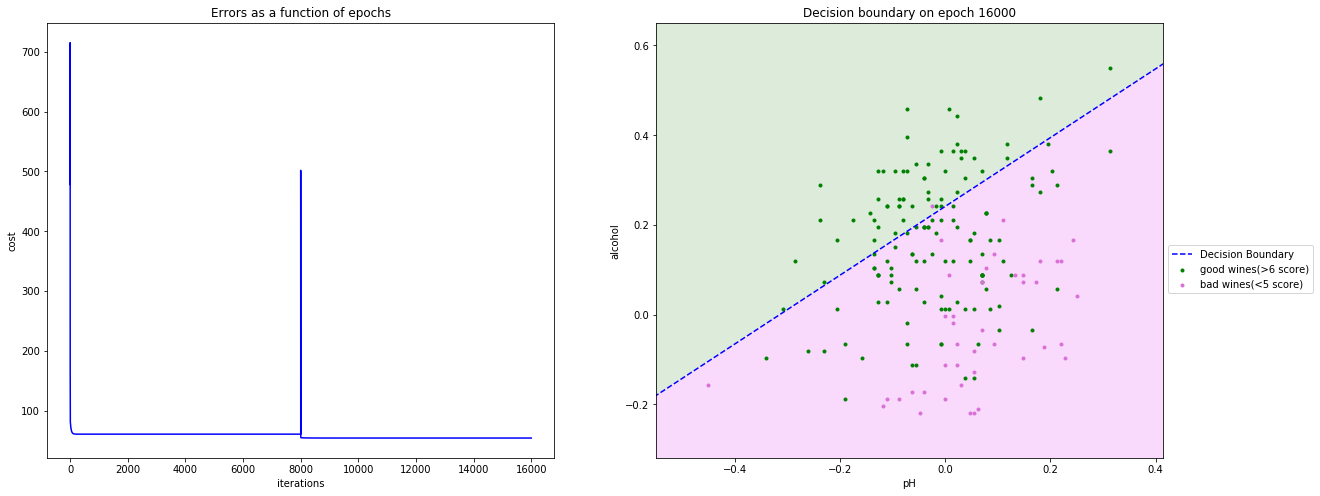

learning rate: 0.001, cost = 54.425524552501074
Learning rate: 0.0001, cost/rows: 0.522815745984863
b = 5.7, w1 = -4.4, w2 = 4.9,    x2 = 0.26-x1*-0.9


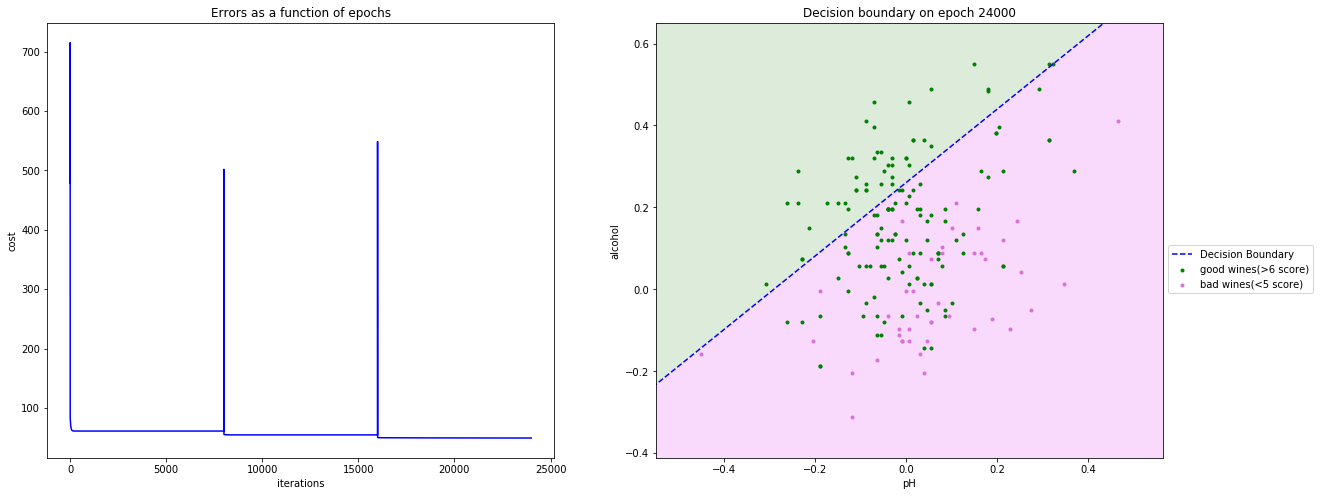

learning rate: 0.0001, cost = 49.14468012257712
Best(lr: 0.0001): w1 = -4.4 w2 = 4.9, bias = 4.1
b = 5.7, w1 = -4.4, w2 = 4.9,    x2 = 0.26-x1*-0.9


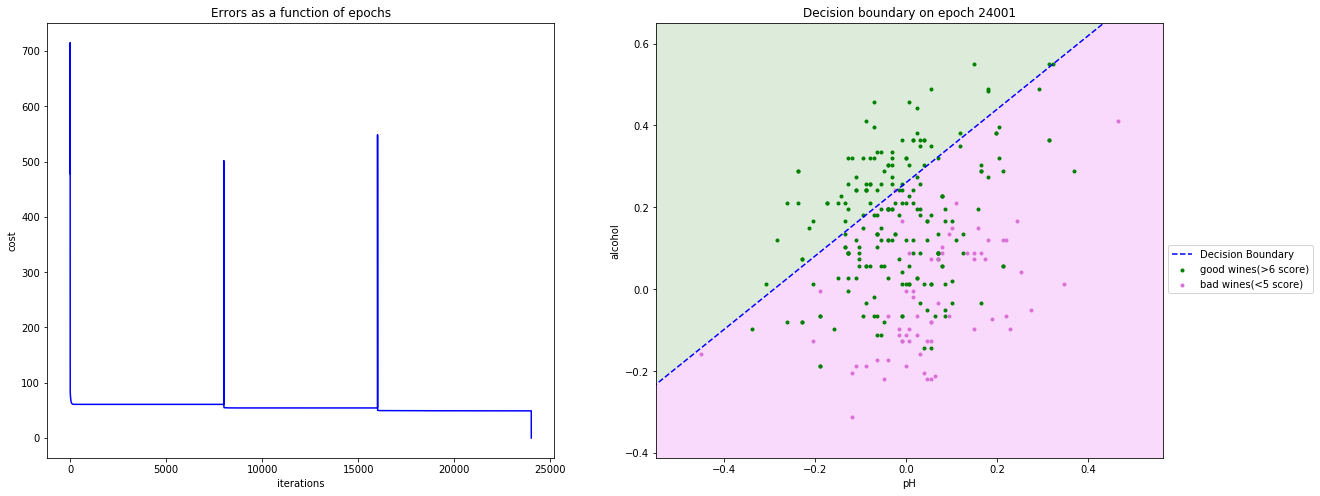

In [9]:
def holdout(wine_data: pd.DataFrame, limits, train_part=0.8):
    wine_data = wine_data[(wine_data.quality >= limits[1]) | (wine_data.quality <= limits[0])]
    train_amount = int(wine_data.shape[0] * train_part)
    shuffled_data = wine_data.sample(frac=1)
    return (shuffled_data[:train_amount], shuffled_data[train_amount:])


def k_fold(wine_data: pd.DataFrame, k=3, shuffle=False):
    wine_data = wine_data[(wine_data.quality <= 4) | (wine_data.quality >= 7)]
    if shuffle:
        wine_data = wine_data.sample(frac=1, random_state=1, axis=0)
    folds = []
    rest = wine_data
    amount = int(wine_data.shape[0] / k)
    res = []
    for i in range(k-1):
        training_temp = rest.sample(n=amount)
        folds.append(training_temp)
        rest = rest.drop(training_temp.index) 
        res.append([folds[i], wine_data.drop(folds[i].index)])
    res.append([rest, wine_data.drop(rest.index)]) # (trainig, validation)
    return res


def training(data, k):
#     tuples = [holdout(red_df, [4, 7])]
    tuples = k_fold(data, k)
    weight_list = [] # tuples [w, bias]
    ada = Adaline(7, 0.01, 8000)
    costs = []
    lr = []
    
    for t in tuples:
        tr, val = t[0], t[1]
        tr.index, val.index = range(len(tr)), range(len(val))
        x = tr[['pH', 'alcohol']].values
        d = tr['quality']
        ada.train(x, d, True, False)
        plot_performance(ada.res, val, 7, 4, ['pH', 'alcohol'], ada.current_epoch)
        weight_list.append([ada.res[-1][2], ada.res[1][3]])
        costs.append(ada.res[-1][1])
        lr.append(ada.learning_rate)
        print(f'learning rate: {lr[-1]}, cost = {costs[-1]}')
        ada.learning_rate *= 0.1
        
    ind = costs.index(min(costs))
    weight1 = weight_list[ind][0][0]
    weight2 = weight_list[ind][0][1]
    bias = weight_list[ind][1]
    print(f'Best(lr: {lr[ind]}): w1 = {round(weight1, 1)} w2 = {round(weight2, 1)}, bias = {round(bias, 1)}')
    ada.res.append([ada.res[-1][0]+1, 0, [weight1, weight2], bias])
    part = data[(data.quality >= 7) | (data.quality <= 4)]
    plot_performance(ada.res, part, 7, 4, ['pH', 'alcohol'], ada.current_epoch + 1)

training(red_df, 3)

### c) 
What effects does changing learning rate and number of training epochs have on the
ADALINE when evaluated via k-fold cross-validation? To address this question,
you should write (or modify) a function that will train and assess the ADALINE
on each training and cross-validation fold produced by your k-fold function.

With k-fold cross validation we can find the fittest learning rate.

## V.5 Adventures in the Nth dimension
### a) Training with >2 factors

types: Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality'],
      dtype='object')
Learning rate: 0.001, cost/rows: 0.5898158218974177
Learning rate: 0.001, cost/rows: 0.451449280907016
Learning rate: 0.001, cost/rows: 0.5999022795123216
Learning rate: 0.001, cost/rows: 1.213518864828005e-21
Learning rate: 0.001, cost/rows: 0.6845557243595719


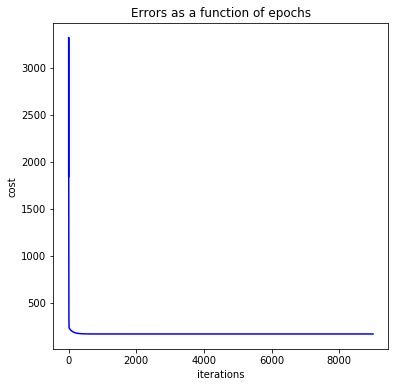

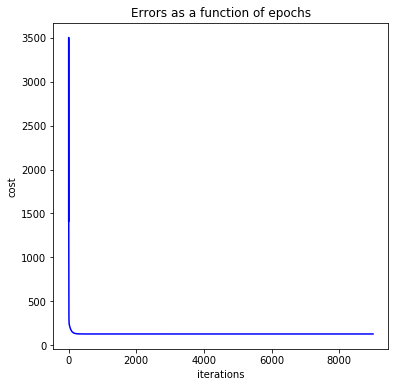

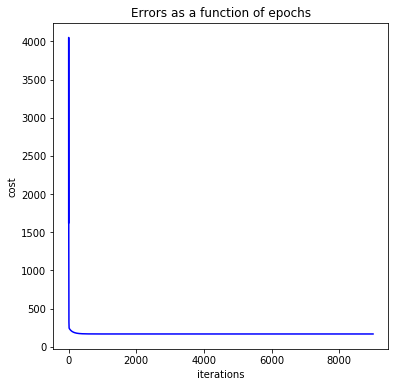

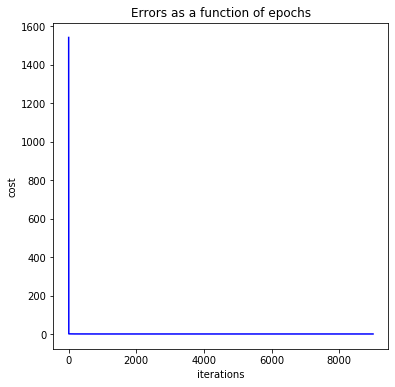

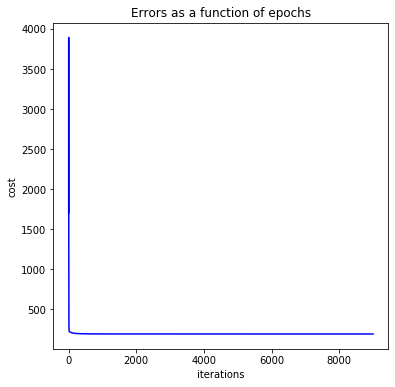

In [10]:
print(f'types: {red_df.columns}')

def multi_factors(wine_data: pd.DataFrame, learning_rate, \
                               factors: list, wines_threshs: list, epochs: int, online=True):
    ada = Adaline(wines_threshs[1], learning_rate, epochs)
    part = wine_data[(wine_data.quality >= wines_threshs[1]) | (wine_data.quality <= wines_threshs[0])]
    part.index = range(len(part))
    x = part[factors].values
    d = part['quality']
    ada.train(x, d, online)
    f, ax = plt.subplots(1, 1, figsize=(6, 6))
    plot_cost(ada.res, ada.res[-1][0], ax)
    return

multi_factors(red_df, 0.001, ['alcohol', 'pH'], [4, 7], 9000, True)
multi_factors(red_df, 0.001, ['alcohol', 'pH', 'volatile acidity'], [4, 7], 9000, True)
multi_factors(red_df, 0.001, ['fixed acidity', 'volatile acidity', 'citric acid'], [4, 7], 9000, True)
multi_factors(red_df, 0.001, ['sulphates', 'alcohol', 'quality'], [4, 7], 9000, True)
multi_factors(red_df, 0.001, ['density', 'alcohol', 'chlorides'], [4, 7], 9000, True)
# V.5

### b) 
You know what the decision boundary for 2 wine chemical factors looks like, but what
does the decision boundary for 3 factors look like? What about if you use 7 factors?
How about if you use all 11 wine chemical factors? 

For N factors its N-dimansional space and decision boundary is hyperlane in tat dimansion.

## V.6 Marvin’s rebuttal
### a)

In [11]:
from matplotlib.patches import Ellipse
import math

df = pd.read_csv("resources/Pan Galactic Gargle Blaster.csv", sep=";")
df = feature_scaling(df)

ppn = Perceptron(9, 0.01, 0)
factors =  [df.columns[0], df.columns[1]]
part = df[(df.quality <= 1) | (df.quality >= 9)]
part.index = range(len(part))
x = part[factors].values.tolist()
x1_sq = [(x[i][0])**2 for i in range(len(x))]
x2_sq = [(x[i][1])**2 for i in range(len(x))]
for j in range(len(x)):
    x[j].append(x[j][0]**2)
    x[j].append(x[j][1]**2)
d = (part['quality'] >= 9).astype(int)
ppn.train(x, d)

Feature scaling is on.
Data scaled.


b = 0.010021540437927356, w1 = 0.004066556609791335, w2 = 0.0018866022661860225, w1sq =-0.10933136296162689, w2sq= -0.09754202142237925


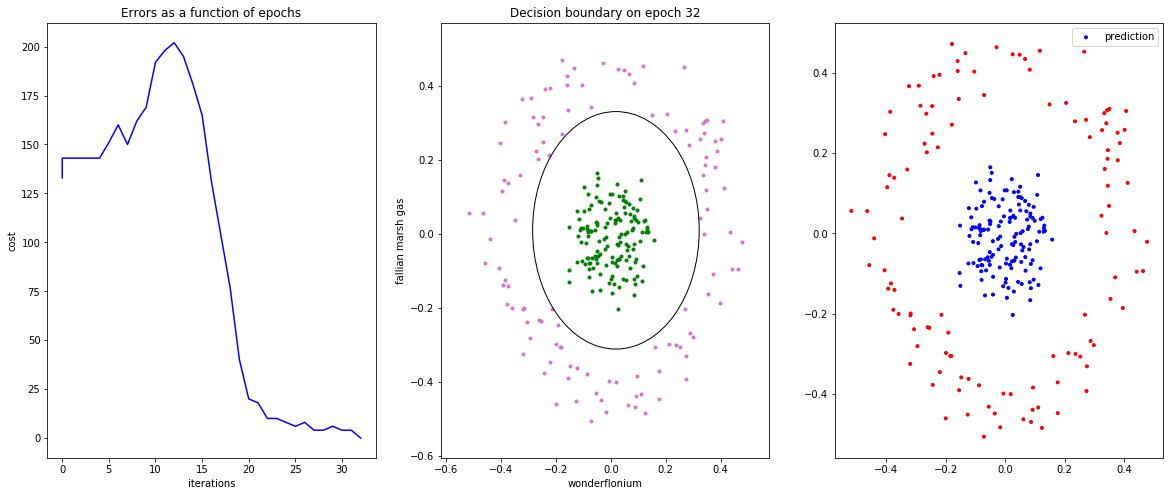

In [12]:
f, ax = plt.subplots(1, 3, figsize=(20, 8))
plot_cost(ppn.res, ppn.res[-1][0], ax[0])

b = ppn.res[-1][3] - 9
w1 = ppn.res[-1][2][0]
w2 = ppn.res[-1][2][1]
w1sq = ppn.res[-1][2][2]
w2sq = ppn.res[-1][2][3]
print(f'b = {b}, w1 = {w1}, w2 = {w2}, w1sq ={w1sq}, w2sq= {w2sq}')

x0 = -w1/(2*w1sq)
y0 = -w2/(2*w2sq)
width_ = math.sqrt( ((w1**2)/(4*w1sq) + (w2**2)/(4*w2sq) - b) / w1sq  )
height_ = math.sqrt( ((w1**2)/(4*w1sq) + (w2**2)/(4*w2sq) - b) / w2sq )
ellipse = Ellipse((x0, y0), width=width_*2, height=height_*2, edgecolor='k', facecolor='none')
ax[1].add_artist(ellipse)

ax[1].set_xlim(min(part[factors[0]].values)-0.1, max(part[factors[0]].values)+0.1)
ax[1].set_ylim(min(part[factors[1]].values)-0.1, max(part[factors[1]].values)+0.1)

bads = df[df.quality <= 1]
xb, yb = bads["wonderflonium"].values, bads["fallian marsh gas"].values
goods = df[df.quality >= 9]
xg, yg = goods["wonderflonium"].values, goods["fallian marsh gas"].values

ax[1].scatter(xg, yg, marker='.', c='green', label=f'good wines(>={9} score)')
ax[1].scatter(xb, yb, marker='.', c='orchid', label=f'bad wines(<{9} score)')
ax[1].set_title(f'Decision boundary on epoch {ppn.res[-1][0]}')
ax[1].set_xlabel(factors[0])
ax[1].set_ylabel(factors[1])
    
x_all = part["wonderflonium"].values
y_all = part["fallian marsh gas"].values
colors = []
for j in range(len(x_all)):
    color = 'b' if ppn.predict(x[j]) else 'r'
    colors.append(color)
ax[2].scatter(x_all, y_all, marker='.', c=colors, label=f'prediction')
plt.legend()
plt.show()

# V.6.v1.end

## VI.2 Do perceptrons dream of electric sheep? (animation)

In [13]:
# Peer into the decision making process of your perceptrons and ADALINEs! 
# Create animated plots of errors as a function of epoch and the changing
# decision boundary of your perceptron and/or ADALINE as a function of epoch. 
# Each time step in your animation should be equivalent to advancing the training epoch by 1!
# You’ll probably want to do some googling on matplotlib animations in jupyter...
# The dockerized jupyter environment comes with everything you need to get animations working though! 
# They’re “libav-tools” and “ffmpeg” if you’re curious...

## VI.3 Dimensional traveler (3d plots)

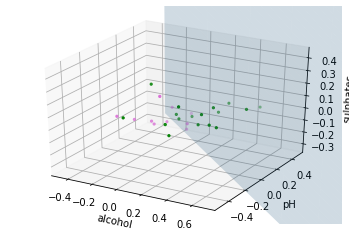

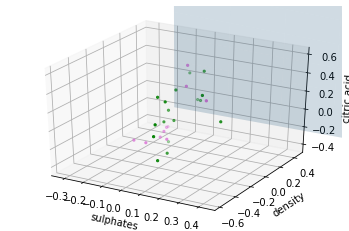

In [48]:
# Create a function that can plot the decision boundary when you train your
# perceptron or ADALINE on 3 different factors! Your plot will of course need to plot 
# the actual wine data points in 3-factor space as well! 
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

def plot_surface_3d(df, factors):
    ppn = Perceptron(8, 0.01, 10000)
    part = df[(df.quality <= 3) | (df.quality >= 8)]
    part.index = range(len(part))
    x = part[factors].values
    d = (part['quality'] >= 8).astype(int)
    ppn.train(x, d)

    w1 = ppn.res[-1][2][0]
    w2 = ppn.res[-1][2][1]
    w3 = ppn.res[-1][2][2]
    b = ppn.res[-1][3]

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    x = [i*0.1 for i in range(0, 80)]
    y = [i*0.1 for i in range(0, 80)]
    z = [[-(b-8+w1*xs[i]+w2*xs[j])/w3 for i in range(len(xs))] for j in range(len(ys))]
    
    goods, bads = part[part.quality >= 8], part[part.quality <= 3]
    xs_g, xs_b = goods[factors[0]].values, bads[factors[0]].values
    ys_g, ys_b = goods[factors[1]].values, bads[factors[1]].values
    zs_g, zs_b = goods[factors[2]].values, bads[factors[2]].values

    ax.set_xlim(min(part[factors[0]])-0.2, max(part[factors[0]])+0.2)
    ax.set_ylim(min(part[factors[1]])-0.2, max(part[factors[1]])+0.2)
    ax.set_zlim(min(part[factors[2]])-0.2, max(part[factors[2]])+0.2)
    ax.set_xlabel(factors[0])
    ax.set_ylabel(factors[1])
    ax.set_zlabel(factors[2])

    ax.plot_surface(x, y, np.array(z), alpha=0.2)
    ax.scatter(xs_g, ys_g, zs_g, c='green', marker='.')
    ax.scatter(xs_b, ys_b, zs_b, c='orchid', marker='.')
    plt.show()

plot_surface_3d(red_df, ['alcohol', 'pH', 'sulphates'])
plot_surface_3d(red_df, ['alcohol', 'pH', 'quality'])
plot_surface_3d(red_df, ['alcohol', 'pH', 'citric acid'])